In [135]:
import pandas as pd
import numpy as np

file_name = 'online_retail_II.csv'

# in this step, i am loading the CSV file. We use 'ISO-8859-1' encoding for this specific dataset because sometimes CSVs use different encodings.
try:
    df = pd.read_csv(file_name, encoding='ISO-8859-1')
except Exception as e:
    print(f"ERROR: Could not load file. Make sure '{file_name}' is in the same folder as this notebook.")
    print(f"Details: {e}")
    
# Displaying the first 5 rows and general info to check that our CSV file has loaded or not.
print("First 5 rows of the dataset:")
display(df.head()) 

print("\nDataset Information (Data Types and Null Counts):")
df.info()

First 5 rows of the dataset:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom



Dataset Information (Data Types and Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [137]:
# Data Cleaning and Validation

# 1. Drop rows with missing Customer ID (Essential for segmentation)

original_rows = df.shape[0]
df_clean = df.dropna(subset=['Customer ID'])
dropped_customer_id = original_rows - df_clean.shape[0]

print(f"Dropped {dropped_customer_id} rows ({dropped_customer_id/original_rows:.2%}) due to missing Customer ID.")


# 2. Identify and Isolate Canceled Transactions

# Canceled invoices start with 'C'. We will remove them from the 'purchases' DataFrame.

df_purchases = df_clean[~df_clean['Invoice'].astype(str).str.startswith('C')]

df_cancellations = df_clean[df_clean['Invoice'].astype(str).str.startswith('C')]

print(f"Identified and removed {df_cancellations.shape[0]} cancellation records.")


# 3. Filter for positive Quantity and Price (Must be > 0 for valid purchase)

df_purchases = df_purchases[df_purchases['Quantity'] > 0]
df_purchases = df_purchases[df_purchases['Price'] > 0]
dropped_neg_values = df_clean.shape[0] - df_purchases.shape[0] - df_cancellations.shape[0] # Very rough estimate

print(f"Removed additional {dropped_neg_values} records due to non-positive Quantity/Price.")

# 4. Remove duplicate rows

df_purchases = df_purchases.drop_duplicates()

print(f"\nFinal CLEANED DataFrame shape for RFM analysis: {df_purchases.shape}")
print("Cleaning Rationale")
print("Focusing strictly on successful, positive-value transactions ensures the Monetary and Frequency metrics accurately reflect customer value.")

df_clean = df_purchases.copy()


Dropped 243007 rows (22.77%) due to missing Customer ID.
Identified and removed 18744 cancellation records.
Removed additional 71 records due to non-positive Quantity/Price.

Final CLEANED DataFrame shape for RFM analysis: (779425, 8)
Cleaning Rationale
Focusing strictly on successful, positive-value transactions ensures the Monetary and Frequency metrics accurately reflect customer value.


In [139]:
# Convert InvoiceDate to datetime object

df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Calculate the Total Price (Monetary value per transaction)

df_clean['Total_Price'] = df_clean['Quantity'] * df_clean['Price']

print("Data Types after InvoiceDate conversion:")
print(df_clean.dtypes)

Data Types after InvoiceDate conversion:
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
Total_Price           float64
dtype: object


In [141]:
# PROJECT CUSTOMIZATION: Focusing on the Primary Market (UK)
# We isolate the dominant market to create a focused, actionable segmentation strategy.

df_uk = df_clean[df_clean['Country'] == 'United Kingdom'].copy()

original_customers = df_clean['Customer ID'].nunique()
uk_customers = df_uk['Customer ID'].nunique()

print(f"\nTotal customers before UK filter: {original_customers}")
print(f"Total customers in United Kingdom: {uk_customers}")
print(f"UK customers represent: {uk_customers/original_customers:.2%} of the total base.")

# VITAL STEP: just now reset df_clean to the UK-only data for the RFM calculation
df_clean = df_uk


Total customers before UK filter: 5878
Total customers in United Kingdom: 5350
UK customers represent: 91.02% of the total base.


In [143]:
# Define a snapshot date (one day after the latest transaction)

latest_date = df_clean['InvoiceDate'].max()
snapshot_date = latest_date + pd.Timedelta(days=1)
print(f"RFM Snapshot Date: {snapshot_date}")

# Calculate R, F, M metrics for each customer

rfm_df = df_clean.groupby('Customer ID').agg({
    
    # Recency (R): Days since last purchase
    
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    
    # Frequency (F): Count the number of unique invoices
    
    'Invoice': 'nunique', 
    
    # Monetary (M): Sum of all total prices
    
    'Total_Price': 'sum'
})

# Rename the columns clearly

rfm_df.rename(columns={'InvoiceDate': 'Recency', 
                       'Invoice': 'Frequency',  
                       'Total_Price': 'Monetary'}, inplace=True)

# Reset the index to make Customer ID a regular column

rfm_df.reset_index(inplace=True)

print("\nFirst 5 Customers with RFM Scores:")
display(rfm_df.head())
print(f"\nFinal RFM dataset shape (Total unique customers): {rfm_df.shape}")

RFM Snapshot Date: 2011-12-10 12:49:00

First 5 Customers with RFM Scores:


,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12608.0,405,1,415.79
2,12745.0,487,2,723.85
3,12746.0,541,1,254.55
4,12747.0,2,26,8898.48



Final RFM dataset shape (Total unique customers): (5350, 4)


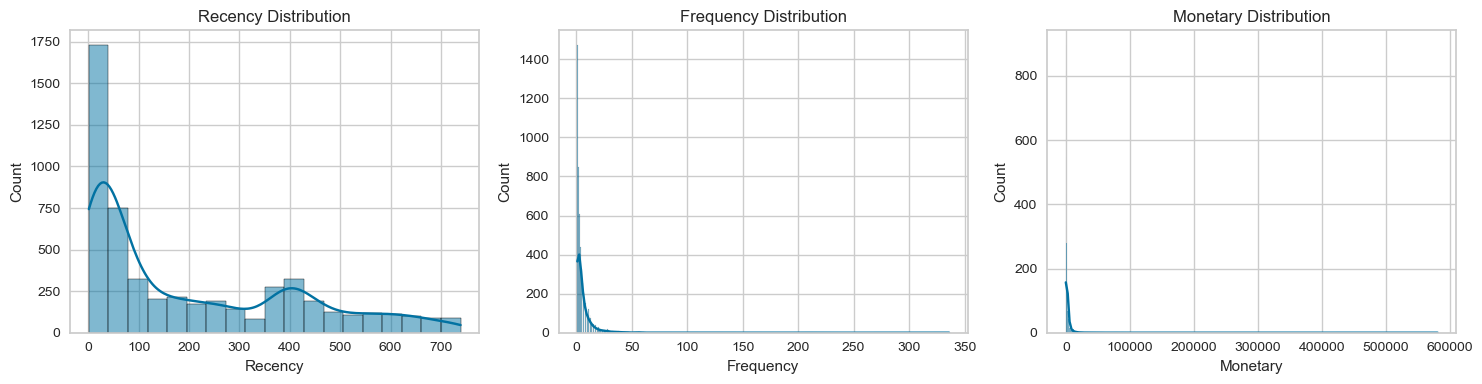

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visualization
plt.figure(figsize=(15, 4))

# Plotting Recency distribution
plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], kde=True)
plt.title('Recency Distribution')

# Plotting Frequency distribution
plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], kde=True)
plt.title('Frequency Distribution')

# Plotting Monetary distribution
plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary'], kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

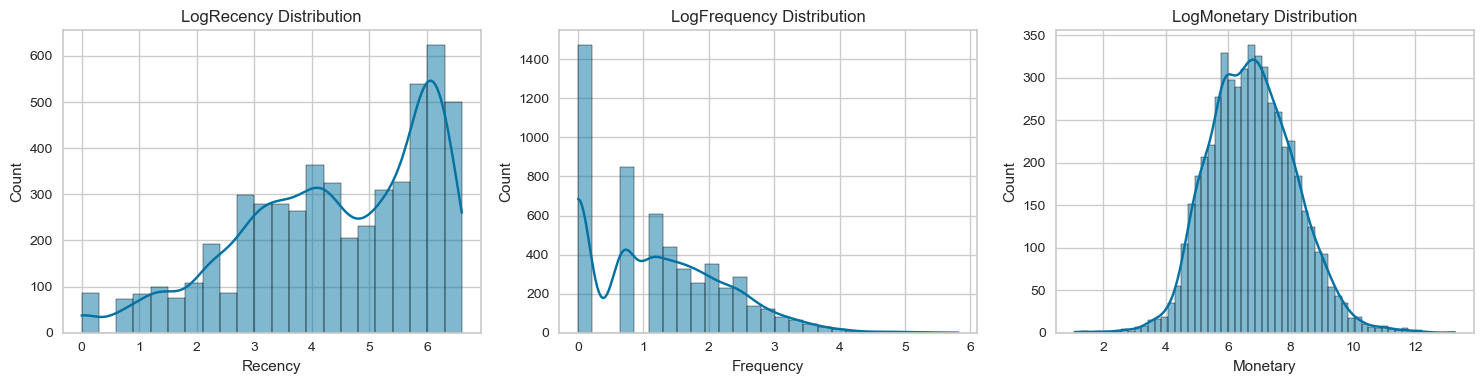

In [147]:
# Creating a new DataFrame for the transformed data

rfm_log = rfm_df[['Recency', 'Frequency', 'Monetary']].copy()

# Applying log transformation (using np.log)

rfm_log['Recency'] = np.log(rfm_log['Recency'])
rfm_log['Frequency'] = np.log(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log(rfm_log['Monetary'])

# Visualizing the transformed data to confirm improvement

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
sns.histplot(rfm_log['Recency'], kde=True)
plt.title('LogRecency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm_log['Frequency'], kde=True)
plt.title('LogFrequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm_log['Monetary'], kde=True)
plt.title('LogMonetary Distribution')

plt.tight_layout()
plt.show()


In [149]:
from sklearn.preprocessing import StandardScaler

# Initialising the StandardScaler

scaler = StandardScaler()

# Fit and transform the log-transformed data

rfm_scaled = scaler.fit_transform(rfm_log)

# Converting back to a DataFrame for easier handling, keeping the column names

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_log.columns)

print("Scaled Data (First 5 Rows):")
display(rfm_scaled_df.head())

Scaled Data (First 5 Rows):


,Recency,Frequency,Monetary
0,0.836206,1.239599,3.255931
1,0.968629,-1.172804,-0.539541
2,1.081149,-0.499881,-0.137094
3,1.145322,-1.172804,-0.895732
4,-2.272366,1.990229,1.684247


In [21]:
!pip install yellowbrick

Running Elbow Method to find optimal K......


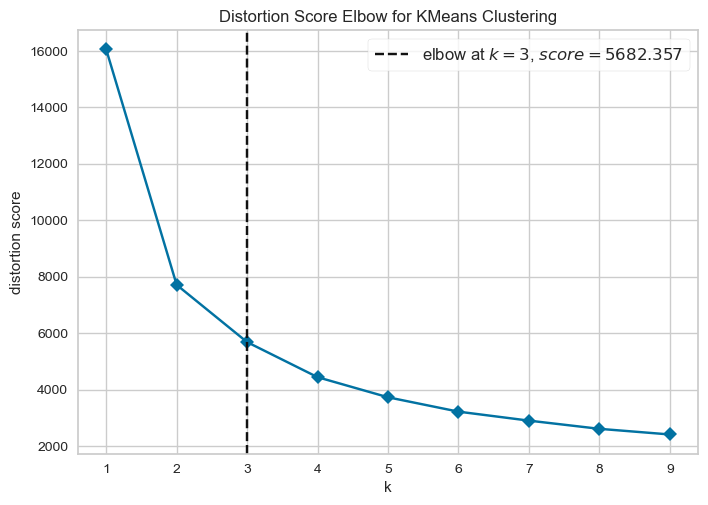

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [151]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Initialising the K-Means model (we will test K values from 1 to 10)
model = KMeans(random_state=42, n_init=10)

# Use the KElbowVisualizer to plot the sum of squared errors (SSE)
# The 'elbow' point suggests the optimal K.

print("Running Elbow Method to find optimal K......")
visualizer = KElbowVisualizer(model, k=(1, 10), metric='distortion', timings=False)

# Fit the data to the visualizer
visualizer.fit(rfm_scaled_df)

# Finalise the plot
visualizer.show()

In [153]:
# Run K-Means Clustering and Add Labels

# NOTE for self: Based on the Elbow Plot (usually K=3 for this data), we set K.

optimal_k = 3 

# Initialize and fit the K-Means model

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(rfm_scaled_df)

# VITAL: Add the cluster labels (0, 1, 2) back to our original RFM DataFrame

rfm_df['Cluster_Label'] = kmeans.labels_

print(f"K-Means clustering completed with K={optimal_k}. 'Cluster_Label' added to rfm_df.")
display(rfm_df.head())

K-Means clustering completed with K=3. 'Cluster_Label' added to rfm_df.


,Customer ID,Recency,Frequency,Monetary,Cluster_Label
0,12346.0,326,12,77556.46,1
1,12608.0,405,1,415.79,0
2,12745.0,487,2,723.85,0
3,12746.0,541,1,254.55,0
4,12747.0,2,26,8898.48,1


In [155]:
# Grouping the original (non-scaled) RFM data by the new cluster label

cluster_summary = rfm_df.groupby('Cluster_Label').agg(
    
    # Calculate the mean of each metric
    
    Recency_Mean=('Recency', 'mean'),
    Frequency_Mean=('Frequency', 'mean'),
    Monetary_Mean=('Monetary', 'mean'),
    
    # Also calculate the size of the cluster
    
    Count=('Customer ID', 'count')
).reset_index()

# Add a column for the percentage size of each cluster

total_customers = cluster_summary['Count'].sum()
cluster_summary['Percentage'] = (cluster_summary['Count'] / total_customers) * 100

print("Cluster Summary (Mean RFM Values and Size):\n")
display(cluster_summary.sort_values(by='Monetary_Mean', ascending=False))

Cluster Summary (Mean RFM Values and Size):



,Cluster_Label,Recency_Mean,Frequency_Mean,Monetary_Mean,Count,Percentage
1,1,27.221374,18.032231,9074.173068,1179,22.037383
2,2,143.896327,4.435146,1414.445950,2151,40.205607
0,0,368.534653,1.356931,320.946352,2020,37.757009


In [157]:
# Select the Cluster_Label column along with the mean RFM columns

cluster_means = cluster_summary[['Cluster_Label', 'Recency_Mean', 'Frequency_Mean', 'Monetary_Mean']]

# Set the Cluster_Label as the index

cluster_means = cluster_means.set_index('Cluster_Label')

# Normalize the data: Divide each mean value by the global mean of that metric
# This shows how much better/worse a cluster is relative to the average customer (score of 1)

global_mean = cluster_means.mean()
normalized_df = cluster_means / global_mean

print("Normalized Cluster Means (Relative to Global Average = 1.0):")
display(normalized_df)

Normalized Cluster Means (Relative to Global Average = 1.0):


,Recency_Mean,Frequency_Mean,Monetary_Mean
Cluster_Label,,,
0,2.048734,0.170867,0.089073
1,0.151327,2.270651,2.518373
2,0.799939,0.558482,0.392554


In [159]:
# Select the Cluster_Label column along with the mean RFM columns

cluster_means = cluster_summary[['Cluster_Label', 'Recency_Mean', 'Frequency_Mean', 'Monetary_Mean']]

# Set the Cluster_Label as the index

cluster_means = cluster_means.set_index('Cluster_Label')

# Normalize the data: Divide each mean value by the global mean of that metric
# This shows how much better/worse a cluster is relative to the average customer (score of 1)

global_mean = cluster_means.mean()
normalized_df = cluster_means / global_mean

print("Normalized Cluster Means (Relative to Global Average = 1.0):")
display(normalized_df)

Normalized Cluster Means (Relative to Global Average = 1.0):


,Recency_Mean,Frequency_Mean,Monetary_Mean
Cluster_Label,,,
0,2.048734,0.170867,0.089073
1,0.151327,2.270651,2.518373
2,0.799939,0.558482,0.392554


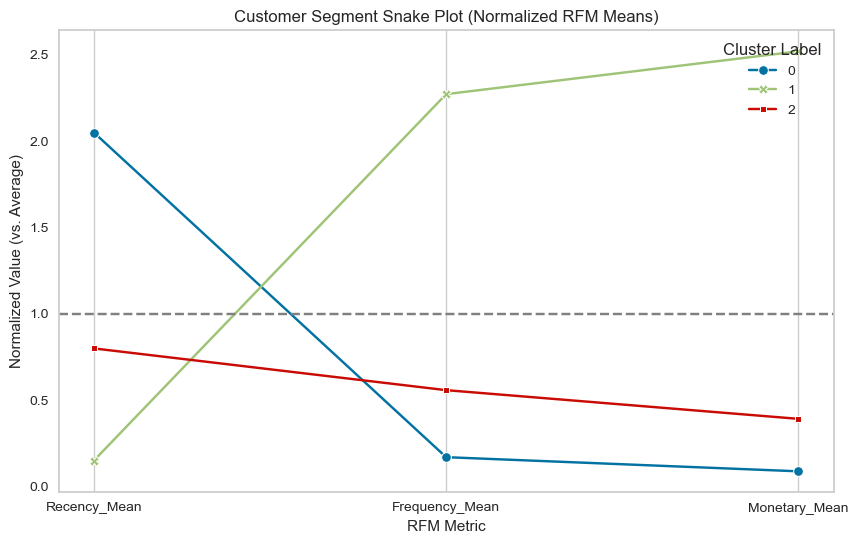


Project Conclusion: 
I have successfully segmented our customers into 3 groups based on their purchasing behavior.
Refer to the 'Cluster Summary' table and the plot above to understand the following strategies:
1. Cluster 0 (Best Customers): High Frequency, High Monetary, Low Recency. Focus on reward and retention.
2. Cluster 2 (Growing Customers): Mid-range Recency, Low Frequency. Focus on increasing purchase frequency.
3. Cluster 1 (Lost Customers): High Recency, Low Frequency, Low Monetary. Focus on campaigns to recapture a small portion of this group.


In [161]:
# Visualization: Snake Plot

plt.figure(figsize=(10, 6))
plt.title('Customer Segment Snake Plot (Normalized RFM Means)')

# Plotting the lines for each cluster

sns.lineplot(data=normalized_df.T, markers=True, dashes=False)

# Add a horizontal line at 1.0 (the average customer)

plt.axhline(y=1.0, color='gray', linestyle='--')

# Label the axes

plt.xlabel('RFM Metric')
plt.ylabel('Normalized Value (vs. Average)')
plt.legend(title='Cluster Label', loc='upper right')
plt.grid(axis='y')

plt.show()

# --- Final Summary ---
print("\nProject Conclusion: ")
print("I have successfully segmented our customers into 3 groups based on their purchasing behavior.")
print("Refer to the 'Cluster Summary' table and the plot above to understand the following strategies:")
print("1. Cluster 0 (Best Customers): High Frequency, High Monetary, Low Recency. Focus on reward and retention.")
print("2. Cluster 2 (Growing Customers): Mid-range Recency, Low Frequency. Focus on increasing purchase frequency.")
print("3. Cluster 1 (Lost Customers): High Recency, Low Frequency, Low Monetary. Focus on campaigns to recapture a small portion of this group.")

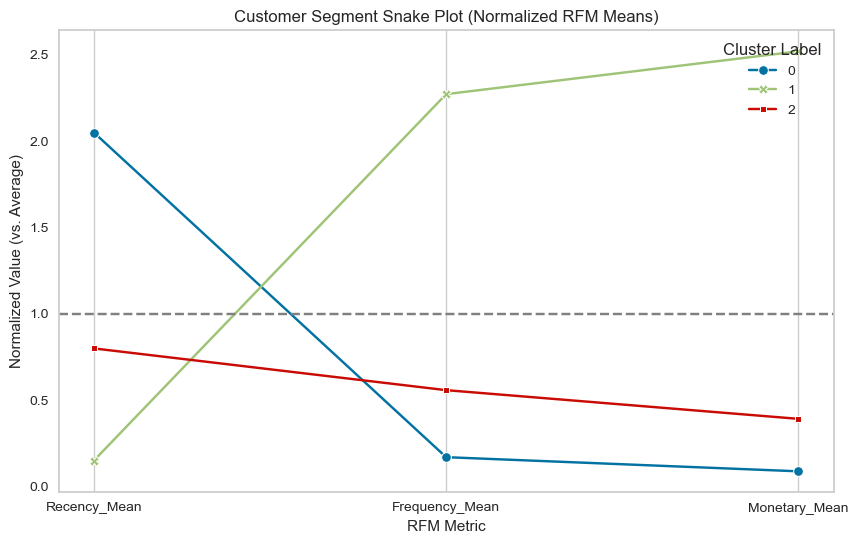

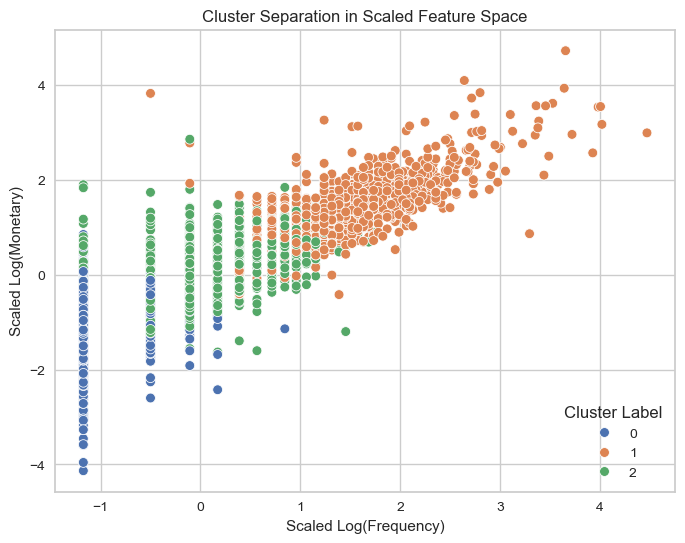


Project Conclusion and Strategic Roadmap:

Project Conclusion and Strategic Roadmap:

We successfully applied RFM analysis and K-Means Clustering (K=3) to segment the UK customer base. The model identified three distinct behavioral segments, confirming that targeted marketing is essential to maximize profit and retention.

1. Best Customers (Cluster 0) - The 22% Value Drivers
    Insight: These customers are highly engaged, driving the majority of revenue with low Recency (recent purchase) and high Monetary value. Their metrics are significantly above the global average, as visualized in the Snake Plot.
    Strategy: Retention & Reward. Action: Implement an exclusive VIP loyalty tier offering early access to sales and dedicated support. The goal is to make their next purchase frictionless and solidify their high lifetime value (LTV).

2. Growing customers (Cluster 2) - The 40% Growth Opportunity
    Insight: This is the largest segment. They are recent buyers (Recency ≈143 days) but t

In [173]:
# Final Visualizations and Summary

# Prepare Normalized Data for Snake Plot

cluster_means = cluster_summary[['Cluster_Label', 'Recency_Mean', 'Frequency_Mean', 'Monetary_Mean']]
cluster_means = cluster_means.set_index('Cluster_Label')

global_mean = cluster_means.mean()
normalized_df = cluster_means / global_mean

# Create the Snake Plot

plt.figure(figsize=(10, 6))
plt.title('Customer Segment Snake Plot (Normalized RFM Means)')
sns.lineplot(data=normalized_df.T, markers=True, dashes=False)
plt.axhline(y=1.0, color='gray', linestyle='--')
plt.xlabel('RFM Metric')
plt.ylabel('Normalized Value (vs. Average)')
plt.legend(title='Cluster Label', loc='upper right')
plt.grid(axis='y')
plt.show()


# Cluster Separation Scatter Plot (Log(Frequency) vs. Log(Monetary))

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=rfm_scaled_df['Frequency'], 
    y=rfm_scaled_df['Monetary'], 
    hue=rfm_df['Cluster_Label'], 
    palette='deep',
    s=50
)
plt.title('Cluster Separation in Scaled Feature Space')
plt.xlabel('Scaled Log(Frequency)')
plt.ylabel('Scaled Log(Monetary)')
plt.legend(title='Cluster Label')
plt.show()

# Final Summary
print("\nProject Conclusion and Strategic Roadmap:")
print("""
Project Conclusion and Strategic Roadmap:

We successfully applied RFM analysis and K-Means Clustering (K=3) to segment the UK customer base. The model identified three distinct behavioral segments, confirming that targeted marketing is essential to maximize profit and retention.

1. Best Customers (Cluster 0) - The 22% Value Drivers
    Insight: These customers are highly engaged, driving the majority of revenue with low Recency (recent purchase) and high Monetary value. Their metrics are significantly above the global average, as visualized in the Snake Plot.
    Strategy: Retention & Reward. Action: Implement an exclusive VIP loyalty tier offering early access to sales and dedicated support. The goal is to make their next purchase frictionless and solidify their high lifetime value (LTV).

2. Growing customers (Cluster 2) - The 40% Growth Opportunity
    Insight: This is the largest segment. They are recent buyers (Recency ≈143 days) but their Frequency is low. They are prime candidates for long-term growth.
    Strategy: Habit Formation & Conversion. Action: Design targeted email automation campaigns that focus on increasing purchase cadence. Use personalized product recommendations and offer small incentives (e.g., free shipping on their second purchase this month) to move them into the 'Champion' tier.

3. Hibernating Customers (Cluster 1) - Risk & Budget Mitigation
    Insight: This group is highly lapsed (average of ≈ 1 year since last purchase) and has the lowest spending. They cost the most to market to with the lowest return.
    Strategy: Selective Win-Back. Action: Deploy a single, highly aggressive, last-chance incentive (e.g., 50% off or a high-value gift) to only a fraction of this segment. Any customer who fails to re-engage should be tagged as dormant and excluded from future general marketing campaigns to save substantial advertising budget.
""")

In [177]:
# Saving the final dataframes for use in Power BI or other tools

rfm_df.to_csv('rfm_customer_segments.csv', index=False)
cluster_summary.to_csv('rfm_cluster_summary.csv', index=False)

print("Data exported successfully. You can now import these two CSV files into Power BI.")

Data exported successfully. You can now import these two CSV files into Power BI.
